In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
from utils.dataset import Dataset
from torch_utils.eval_metric_model import evaluate
from torch_utils.eval_metric_model import process_generator
from utils.test_generator import TestGenerator
from torch_model.metric_learning_model import Resnet50MetricLearning

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
more_path = "../MoRe---ReID-Codes/MoRe.hdf5"
more = Dataset(more_path, to_bgr = True) # Images were used in BGR format

_, idsa = more.content_array(partition='train', cam_name='camA')
_, idsb = more.content_array(partition='train', cam_name='camB')

total_images_train = len(idsa) + len(idsb)
target_ident_num = more.ident_num(partition='train')

In [57]:
print('Processing cams images')
test_gen_camA = TestGenerator(more, partition='test', cam='camA', image_shape=(256,256))
test_gen_camB = TestGenerator(more, partition='test', cam='camB', image_shape=(256,256))
if device == 'cuda':
    torch.cuda.empty_cache()
    
metric_learning_model_weights = 'weights/torch.quad_loss.120epochs.pt'

model_metric = Resnet50MetricLearning(target_ident_num, inference=False).eval().to(device)
incompatible_keys = model_metric.load_state_dict(torch.load(metric_learning_model_weights), strict=False, )
print('Keys not loaded:', incompatible_keys)

probe_features_no_center, ids_camA_no_center = process_generator(test_gen_camA, model_metric, batch_size=96, workers=1)


Processing cams images
Keys not loaded: _IncompatibleKeys(missing_keys=['batch_norm.weight', 'batch_norm.bias', 'batch_norm.running_mean', 'batch_norm.running_var'], unexpected_keys=[])


100%|██████████| 39/39 [00:17<00:00,  2.25it/s]


In [59]:
import pandas as pd
import numpy as np

values, counts = np.unique(ids_camA_no_center, return_counts=True)

indexes = np.argsort(counts)[::-1]
selected_ids = values[indexes]
selected_features = probe_features_no_center[np.isin(ids_camA_no_center, selected_ids)]
selected_targets = ids_camA_no_center[np.isin(ids_camA_no_center, selected_ids)]
df = pd.DataFrame()
df.index = np.arange(len(selected_features))
df.loc[:, 'features'] = [*selected_features]
df.loc[:, 'ids'] = selected_targets


gdf_no_center = df.groupby('ids').features.apply(np.mean).reset_index()
gdf_no_center

,ids,features
0,5,"[0.057985462, 0.05420101, 0.06639986, 0.012429..."
1,7,"[0.03318697, 0.21929269, 0.011075665, 0.043289..."
2,8,"[0.17486162, 0.12576376, 0.058039505, 0.027559..."
3,10,"[0.10645791, 0.07596429, 0.16330585, 0.0799751..."
4,11,"[0.09706628, 0.13950542, 0.0048605925, 0.01397..."
...,...,...
1909,3820,"[0.0, 0.0, 0.04468213, 0.04946493, 0.040892195..."
1910,3822,"[4.5944704e-05, 0.11090809, 0.029595667, 0.126..."
1911,3823,"[0.0, 0.0049331924, 0.16197152, 0.10919467, 0...."
1912,3824,"[0.009148002, 0.019807622, 0.048091333, 0.0162..."


In [61]:
from sklearn.metrics.pairwise import cosine_similarity

sims = cosine_similarity(gdf_no_center.features.tolist(), gdf_no_center.features.tolist())
num_distances = (len(gdf_no_center)**2 - len(gdf_no_center) )/ 2
np.tril(sims, k=-1).sum()/ num_distances

0.4771363412410603

In [66]:
1 - 42.14/47.71

0.11674701320477887

In [31]:
import sklearn.datasets
# import pandas as pd
import numpy as np
import umap

reducer = umap.UMAP(random_state=42)

reducer.fit(gdf_no_center.features.tolist())

c:\Users\Augusto\anaconda3\envs\new-more\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Augusto\anaconda3\envs\new-more\lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [32]:
embedding = reducer.transform(gdf.features.tolist())
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(10, 2)

In [34]:
colors = np.random.rand(len(gdf), 3)

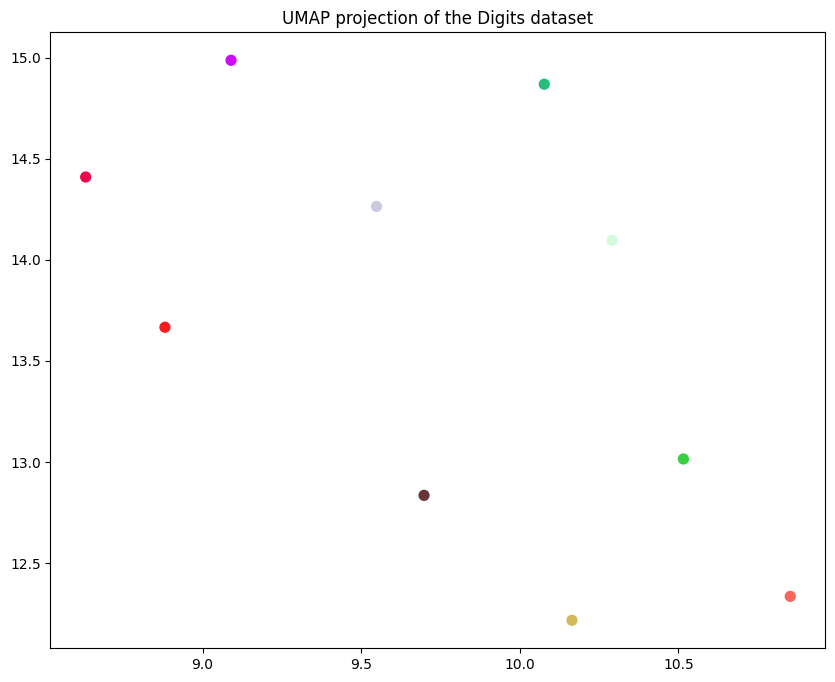

In [35]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(10,8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=50)
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=12)
plt.show()

In [62]:
print('Processing cams images')
test_gen_camA = TestGenerator(more, partition='test', cam='camA', image_shape=(256,256))
test_gen_camB = TestGenerator(more, partition='test', cam='camB', image_shape=(256,256))
if device == 'cuda':
    torch.cuda.empty_cache()
    
metric_learning_model_weights = 'weights/torch.quad_loss(0.9).center_loss(1e-2).120epochs.pt'

model_metric = Resnet50MetricLearning(target_ident_num, inference=False).eval().to(device)
incompatible_keys = model_metric.load_state_dict(torch.load(metric_learning_model_weights), strict=False, )
print('Keys not loaded:', incompatible_keys)


probe_features_center, ids_camA_center = process_generator(test_gen_camA, model_metric, batch_size=96, workers=1)

# gallery_features, ids_camB = process_generator(test_gen_camB, model_metric, batch_size=96, workers=1)
# print(f'Loaded {len(ids_camB)} samples for cam B')



Processing cams images
Keys not loaded: _IncompatibleKeys(missing_keys=['batch_norm.weight', 'batch_norm.bias', 'batch_norm.running_mean', 'batch_norm.running_var'], unexpected_keys=[])


100%|██████████| 39/39 [00:17<00:00,  2.25it/s]


In [63]:
import pandas as pd
import numpy as np

values, counts = np.unique(ids_camA_center, return_counts=True)

indexes = np.argsort(counts)[::-1][:10]
selected_ids = values[indexes]
selected_features = probe_features_center[np.isin(ids_camA_center, selected_ids)]
selected_targets = ids_camA_center[np.isin(ids_camA_center, selected_ids)]

df = pd.DataFrame()
df.index = np.arange(len(selected_features))
df.loc[:, 'features'] = [*selected_features]
df.loc[:, 'ids'] = selected_targets


gdf_center = df.groupby('ids').features.apply(np.mean).reset_index()
gdf_center

,ids,features
0,988,"[0.0016839894, 0.020304952, 0.1073505, 0.00710..."
1,2012,"[0.00467705, 0.056443613, 0.060253948, 0.00183..."
2,2037,"[0.019111905, 0.06503816, 0.0075601134, 0.0017..."
3,2290,"[0.008463793, 0.10283183, 0.035037287, 0.0, 0...."
4,2315,"[0.017887259, 0.030856384, 0.024826672, 0.0341..."
5,2369,"[0.014987597, 0.08068278, 0.0055959816, 0.0205..."
6,2594,"[0.030093085, 0.043297313, 0.048966773, 0.0004..."
7,3387,"[0.006033237, 0.0012250365, 0.07561064, 0.0979..."
8,3417,"[0.00037860774, 0.0032330595, 0.003248179, 0.1..."
9,3559,"[0.00011738516, 0.010798717, 0.011917171, 0.15..."


In [64]:
from sklearn.metrics.pairwise import cosine_similarity

sims = cosine_similarity(gdf_center.features.tolist(), gdf_center.features.tolist())
num_distances = (len(gdf_center)**2 - len(gdf_center) )/ 2
np.tril(sims, k=-1).sum()/ num_distances

0.4214274088541667

c:\Users\Augusto\anaconda3\envs\new-more\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Augusto\anaconda3\envs\new-more\lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


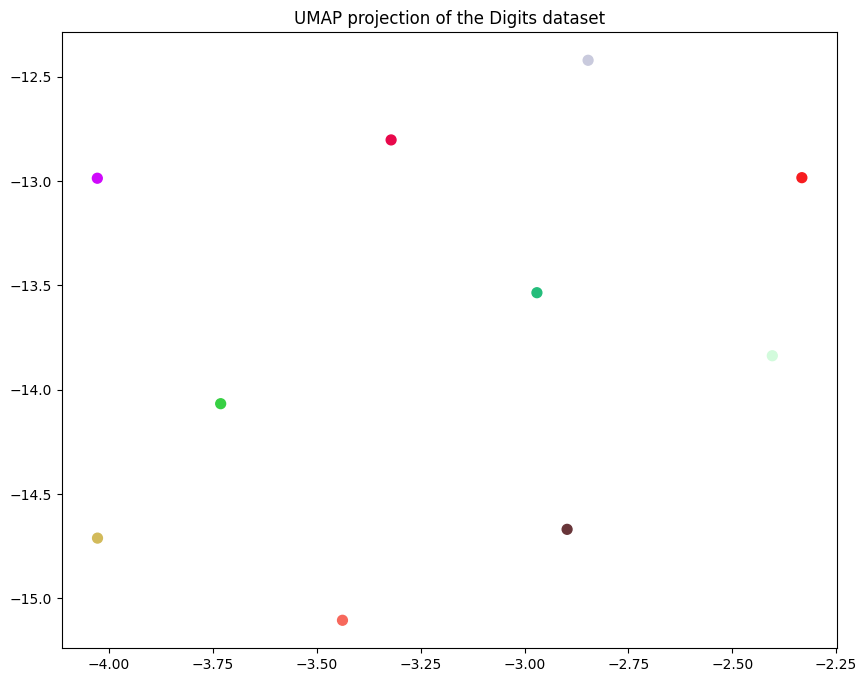

In [55]:
import sklearn.datasets
# import pandas as pd
import numpy as np
import umap

reducer = umap.UMAP(random_state=42)

reducer.fit(gdf.features.tolist())

embedding = reducer.transform(gdf.features.tolist())
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(10,8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=50)
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=12)
plt.show()

In [2]:
import numpy as np

fa = np.random.rand(3400, 2048)
fb = np.random.rand(3600, 2048)


In [6]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
a = cosine_similarity(fa, fb)

In [8]:
b = cdist(fa, fb, metric='cosine')

In [9]:
a[0]

array([0.75471983, 0.74573316, 0.74843596, ..., 0.73848099, 0.75334301,
       0.75675894])

In [12]:
a

array([[0.75471983, 0.74573316, 0.74843596, ..., 0.73848099, 0.75334301,
        0.75675894],
       [0.75046292, 0.75583273, 0.75229193, ..., 0.74545208, 0.75148172,
        0.75777674],
       [0.75238521, 0.75691429, 0.75319257, ..., 0.74498736, 0.74434734,
        0.75388617],
       ...,
       [0.74429203, 0.75456996, 0.74335283, ..., 0.73816507, 0.74314268,
        0.75909511],
       [0.75185471, 0.76186809, 0.75502739, ..., 0.73254915, 0.75076105,
        0.75004453],
       [0.7565397 , 0.74735025, 0.75038808, ..., 0.73427336, 0.7517122 ,
        0.75338529]])